In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import pandas_datareader.data as web
from datetime import datetime, timedelta

In [ ]:
start = datetime(2015, 1, 1)
end = datetime(2019, 1, 1)
# Fetch data using yfinance
df = yf.download('GOOGL', start=start, end=end)

[*********************100%%**********************]  1 of 1 completed


In [ ]:
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-01-02,26.629999,26.790001,26.393999,26.477501,26.447147,26480000
2015-01-05,26.357500,26.399500,25.887501,25.973000,25.943224,41182000
2015-01-06,26.025000,26.060499,25.277500,25.332001,25.302961,54456000
2015-01-07,25.547501,25.574499,25.182501,25.257500,25.228544,46918000
2015-01-08,25.075500,25.375000,24.750999,25.345501,25.316446,73054000
...,...,...,...,...,...,...
2018-12-24,49.216000,50.605999,48.882999,49.233501,49.177063,36360000
2018-12-26,49.899502,52.422501,49.632500,52.392502,52.332439,46318000
2018-12-27,51.310001,52.667000,50.349998,52.645000,52.584648,45996000


In [ ]:
#df = df['Close'].resample('W').mean()
#set index for pycaret modelling
#df.set_index('Date', inplace=True)
df = df['Close']
df = df.asfreq('D')
df = df.interpolate()
df2 = df.copy()
df.info()

<class 'pandas.core.series.Series'>
DatetimeIndex: 1460 entries, 2015-01-02 to 2018-12-31
Freq: D
Series name: Close
Non-Null Count  Dtype  
--------------  -----  
1460 non-null   float64
dtypes: float64(1)
memory usage: 22.8 KB


In [ ]:
df

,Close
Date,
2015-01-02,26.477501
2015-01-03,26.309334
2015-01-04,26.141167
2015-01-05,25.973000
2015-01-06,25.332001
...,...
2018-12-27,52.645000
2018-12-28,52.334000
2018-12-29,52.305333


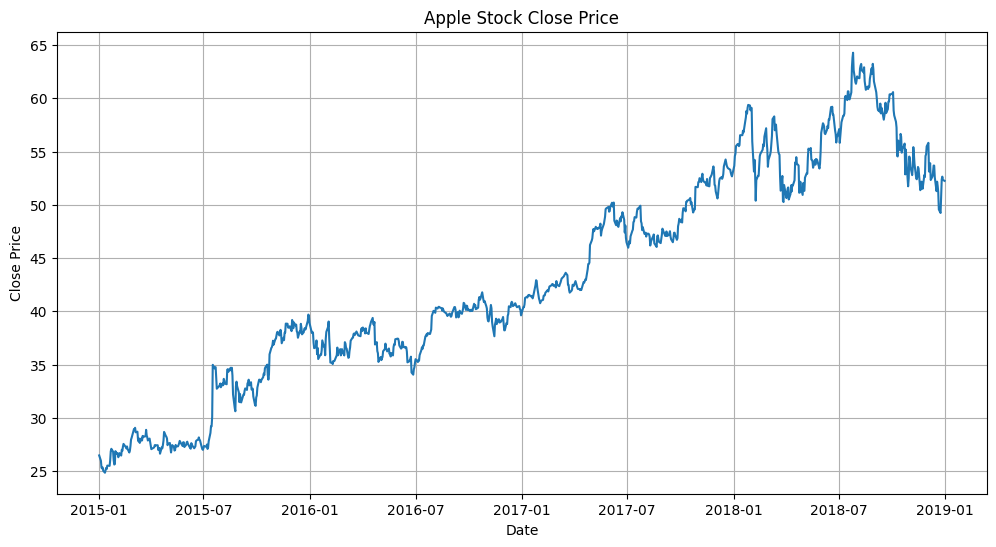

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(df)
plt.title('Apple Stock Close Price')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.grid(True)
plt.show()

In [ ]:
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, kpss
from scipy.stats import shapiro

def test_white_noise(series):
    # Ljung-Box test for white noise
    result = sm.stats.acorr_ljungbox(series, lags=[10], return_df=True)
    return result

def test_stationarity(series):
    # Use ADF and KPSS tests for stationarity
    adf_result = adfuller(series)
    kpss_result, p_value, lags, critical_values = kpss(series, regression='c')
    return adf_result, kpss_result

def test_adf(series):
    # Augmented Dickey-Fuller test
    result = adfuller(series)
    return result

def test_kpss(series):
    # Kwiatkowski-Phillips-Schmidt-Shin test
    result = kpss(series, regression='c')
    return result

def test_normality(series):
    # Shapiro-Wilk test for normality
    result = shapiro(series)
    return result

def run_all_tests(series):
    white_noise_result = test_white_noise(series)
    stationarity_adf_result, stationarity_kpss_result = test_stationarity(series)
    adf_result = test_adf(series)
    kpss_result = test_kpss(series)
    normality_result = test_normality(series)

    return {
        'White Noise Test': white_noise_result,
        'ADF Stationarity Test': adf_result,
        'KPSS Stationarity Test': kpss_result,
        'Normality Test': normality_result,
    }

def explain_results(results):
    explanations = {}

    # White Noise Test Explanation
    white_noise_result = results['White Noise Test']
    explanations['White Noise Test'] = (
        "Hypothesis: \n"
        "H0: The series is white noise.\n"
        "H1: The series is not white noise.\n"
        f"p-value: {white_noise_result['lb_pvalue'].iloc[0]}\n"
        f"Reject H0: {white_noise_result['lb_pvalue'].iloc[0] < 0.05}\n"
    )

    # ADF Stationarity Test Explanation
    adf_result = results['ADF Stationarity Test']
    explanations['ADF Stationarity Test'] = (
        "Hypothesis: \n"
        "H0: The series has a unit root (non-stationary).\n"
        "H1: The series is stationary.\n"
        f"ADF Statistic: {adf_result[0]}\n"
        f"p-value: {adf_result[1]}\n"
        f"Critical Values: {adf_result[4]}\n"
        f"Reject H0: {adf_result[1] < 0.05}\n"
    )

    # KPSS Stationarity Test Explanation
    kpss_result = results['KPSS Stationarity Test']
    explanations['KPSS Stationarity Test'] = (
        "Hypothesis: \n"
        "H0: The series is stationary.\n"
        "H1: The series is not stationary.\n"
        f"KPSS Statistic: {kpss_result[0]}\n"
        f"p-value: {kpss_result[1]}\n"
        f"Critical Values: {kpss_result[3]}\n"
        f"Reject H0: {kpss_result[1] < 0.05}\n"
    )

    # Normality Test Explanation
    normality_result = results['Normality Test']
    explanations['Normality Test'] = (
        "Hypothesis: \n"
        "H0: The data is normally distributed.\n"
        "H1: The data is not normally distributed.\n"
        f"Statistic: {normality_result[0]}\n"
        f"p-value: {normality_result[1]}\n"
        f"Reject H0: {normality_result[1] < 0.05}\n"
    )

    return explanations

results = run_all_tests(df)
explanations = explain_results(results)

print("White Noise Test Results:")
print(explanations['White Noise Test'])
print("\nADF Stationarity Test Results:")
print(explanations['ADF Stationarity Test'])
print("\nKPSS Stationarity Test Results:")
print(explanations['KPSS Stationarity Test'])
print("\nNormality Test Results:")
print(explanations['Normality Test'])

<ipython-input-7-50c345cd9e46>:13: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result, p_value, lags, critical_values = kpss(series, regression='c')


White Noise Test Results:
Hypothesis: 
H0: The series is white noise.
H1: The series is not white noise.
p-value: 0.0
Reject H0: True


ADF Stationarity Test Results:
Hypothesis: 
H0: The series has a unit root (non-stationary).
H1: The series is stationary.
ADF Statistic: -1.5121808560402084
p-value: 0.5274772686713769
Critical Values: {'1%': -3.434843038681996, '5%': -2.8635243777871286, '10%': -2.56782646544019}
Reject H0: False


KPSS Stationarity Test Results:
Hypothesis: 
H0: The series is stationary.
H1: The series is not stationary.
KPSS Statistic: 5.376446333808722
p-value: 0.01
Critical Values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}
Reject H0: True


Normality Test Results:
Hypothesis: 
H0: The data is normally distributed.
H1: The data is not normally distributed.
Statistic: 0.962223044376252
p-value: 4.87422943355724e-19
Reject H0: True



<ipython-input-7-50c345cd9e46>:23: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series, regression='c')


## pycaret

In [ ]:
!pip install pycaret

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 kB 10.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached jedi-0.19.1-py2.py3-none-any.whl.metadata (22 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 486.1/486.1 kB 24.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.8/106.8 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.8/21.8 MB 62.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.2/302.2 kB 20.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.7/80.7 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 56.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━

In [ ]:
from pycaret.time_series import *
s = setup(df ,fh = 3, fold = 5, session_id = 123)

,Description,Value
0,session_id,123
1,Target,Close
2,Approach,Univariate
3,Exogenous Variables,Not Present
4,Original data shape,"(1460, 1)"
5,Transformed data shape,"(1460, 1)"
6,Transformed train set shape,"(1457, 1)"
7,Transformed test set shape,"(3, 1)"
8,Rows with missing values,0.0%
9,Fold Generator,ExpandingWindowSplitter


In [ ]:
best = compare_models()

,Model,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2,TT (Sec)
auto_arima,Auto ARIMA,3.6970,2.4369,1.1180,1.2178,0.0218,0.0217,-29.6525,4.0980
arima,ARIMA,3.8007,2.5033,1.1495,1.2512,0.0224,0.0223,-34.9994,0.6180
naive,Naive Forecaster,3.8064,2.5050,1.1512,1.2520,0.0224,0.0223,-34.3745,2.2420
exp_smooth,Exponential Smoothing,3.8171,2.5103,1.1544,1.2545,0.0225,0.0224,-33.4110,0.0920
ets,ETS,3.8172,2.5103,1.1544,1.2546,0.0225,0.0224,-33.4196,0.1040
theta,Theta Forecaster,3.8197,2.5091,1.1551,1.2539,0.0225,0.0224,-33.3534,0.1160
huber_cds_dt,Huber w/ Cond. Deseasonalize & Detrending,3.8992,2.5305,1.1790,1.2645,0.0230,0.0229,-31.6472,0.1600
lr_cds_dt,Linear w/ Cond. Deseasonalize & Detrending,3.9942,2.5604,1.2074,1.2791,0.0236,0.0234,-27.3050,0.4820
omp_cds_dt,Orthogonal Matching Pursuit w/ Cond. Deseasonalize & Detrending,3.9942,2.5604,1.2074,1.2791,0.0236,0.0234,-27.3050,0.1580
br_cds_dt,Bayesian Ridge w/ Cond. Deseasonalize & Detrending,3.9944,2.5605,1.2075,1.2792,0.0236,0.0234,-27.2956,0.1480


Processing:   0%|          | 0/109 [00:00<?, ?it/s]

In [ ]:
print(best)

AutoARIMA(random_state=123, suppress_warnings=True)


In [ ]:
# functional API
plot_model(best, plot = 'diagnostics')

In [ ]:
# functional API
plot_model(best, plot = 'insample')

In [ ]:
# functional API
final_best = finalize_model(best)
predict_model(best, fh = 24)

,y_pred
2018-12-29,52.3045
2018-12-30,52.3045
2018-12-31,52.3045
2019-01-01,52.3045
2019-01-02,52.3045
2019-01-03,52.3045
2019-01-04,52.3045
2019-01-05,52.3045
2019-01-06,52.3045
2019-01-07,52.3045


In [ ]:
# functional API
plot_model(best, plot = 'forecast', data_kwargs = {'fh' : 360})

In [ ]:
save_model(final_best, 'final_best_model')

Transformation Pipeline and Model Successfully Saved


(ForecastingPipeline(steps=[('forecaster',
                             TransformedTargetForecaster(steps=[('model',
                                                                 ForecastingPipeline(steps=[('forecaster',
                                                                                             TransformedTargetForecaster(steps=[('model',
                                                                                                                                 AutoARIMA(random_state=123,
                                                                                                                                           suppress_warnings=True))]))]))]))]),
 'final_best_model.pkl')

In [ ]:
df2 = df2.reset_index()
df2.columns = ['ds', 'y']
df2

,ds,y
0,2015-01-02,26.477501
1,2015-01-03,26.309334
2,2015-01-04,26.141167
3,2015-01-05,25.973000
4,2015-01-06,25.332001
...,...,...
1455,2018-12-27,52.645000
1456,2018-12-28,52.334000
1457,2018-12-29,52.305333
1458,2018-12-30,52.276667


## prophet

In [ ]:
from prophet import Prophet
from prophet.diagnostics import performance_metrics
from prophet.diagnostics import cross_validation
from prophet.plot import plot_plotly,plot_forecast_component_plotly,plot_seasonality_plotly, plot_components_plotly ,plot_cross_validation_metric
model = Prophet(interval_width = 0.95)
model.fit(df2)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpja04go_f/kf4stcot.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpja04go_f/e8hqi613.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=15761', 'data', 'file=/tmp/tmpja04go_f/kf4stcot.json', 'init=/tmp/tmpja04go_f/e8hqi613.json', 'output', 'file=/tmp/tmpja04go_f/prophet_modele0w2foa9/prophet_model-20240817035026.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:50:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:50:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
future_dates = model.make_future_dataframe(periods=360, freq='D')
future_dates.tail()

,ds
1815,2019-12-22
1816,2019-12-23
1817,2019-12-24
1818,2019-12-25
1819,2019-12-26


In [ ]:
forecast = model.predict(future_dates)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head()

,ds,yhat,yhat_lower,yhat_upper
0,2015-01-02,25.755799,23.588203,28.032718
1,2015-01-03,25.762431,23.410485,27.865183
2,2015-01-04,25.778842,23.479926,27.933288
3,2015-01-05,25.804941,23.584678,28.140143
4,2015-01-06,25.875707,23.670856,28.163692


In [ ]:
fig = plot_plotly(model, forecast, uncertainty=True)
fig.update_layout(title_text='Google Stock Price Forecast')
fig.show()

In [ ]:
fig2 = plot_components_plotly(model, forecast)
fig2.show()

In [ ]:
# model evaluation
df_cv = cross_validation(model, initial='730 days', period='180 days', horizon='365 days')
df_p = performance_metrics(df_cv)
df_p.head()

INFO:prophet:Making 3 forecasts with cutoffs between 2017-01-05 00:00:00 and 2017-12-31 00:00:00


  0%|          | 0/3 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpja04go_f/5o50e0w_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpja04go_f/qenc2ifs.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=17336', 'data', 'file=/tmp/tmpja04go_f/5o50e0w_.json', 'init=/tmp/tmpja04go_f/qenc2ifs.json', 'output', 'file=/tmp/tmpja04go_f/prophet_modeli7g7lr_e/prophet_model-20240817035028.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:50:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:50:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpja04go_f/s11pmjf7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpja04go_f/y692nay5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,37 days,30.877435,5.556747,4.989404,0.102629,0.086705,0.101686,0.021407
1,38 days,32.083247,5.664208,5.079677,0.104600,0.087251,0.103462,0.021407
2,39 days,33.253768,5.766608,5.164301,0.106474,0.087338,0.105138,0.027523
3,40 days,34.371194,5.862695,5.237989,0.108127,0.088203,0.106599,0.036697
4,41 days,35.412455,5.950836,5.303506,0.109619,0.091274,0.107896,0.045872


In [ ]:
mse = df_p['mse'].mean()
mae = df_p['mae'].mean()
rmse = df_p['rmse'].mean()
mape = df_p['mape'].mean()

print(f"MSE: {mse}")
print(f"MAE: {mae}")
print(f"RMSE: {rmse}")
print(f"MAPE: {mape}")

MSE: 125.79065863305597
MAE: 10.017850793640271
RMSE: 10.977812110329607
MAPE: 0.19128075370929148


Berdasarkan hasil forecasting kedua model, dapat ditarik kesimpulan bahwa model Pycaret mendapatkan metrics error (MAE, MAPE, RMSE) 3.6970	2.4369	1.1180	1.2178	0.0218	0.0217	-29.6525 daripada Prophet, tetapi hasil out of sample forecast Pycaret menunjukkan bahwa harga saham akan menurun sedangkan hasil out of sample forecast Prophet menunjukkan bahwa harga saham akan tetap stasioner.